<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Modeling groundwater flow in a conceptual catchment

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial demonstrates how the GroundwaterDupuitPercolator can be used to model groundwater flow and seepage (groundwater return flow). It is recommended to read the documentation for the component before starting this tutorial to be familiar with the mechanics of the model.

In this tutorial you will:
* Create a raster grid on which to run the model
* Simulate constant recharge and check that the component conserves mass
* Confirm conservation of mass when the recharge rate and timestep are changed
* Simulate recharge from storm events, check conservation of mass, and look at the outflow hydrograph
* Learn how to set fixed gradient boundaries and set values for the hydraulic gradient

### Import libraries

In [70]:
import numpy as np
import matplotlib.pyplot as plt

from landlab import RasterModelGrid, imshow_grid
from landlab.components import GroundwaterDupuitPercolator, FlowAccumulator
from landlab.components.uniform_precip import PrecipitationDistribution

## Create a RasterModelGrid

Here you will make the grid on which we will run the model. You will create three fields: topographic elevation, aquifer base elevation, and initial water table elevation

In [71]:
def construct_topo(x,y):
    #z(500,800)=0
    z= abs(800-x)*0.05+(1000-y)*0.02
    return z
    

In [72]:
boundaries = {'top': 'closed','bottom': 'open','right':'closed','left':'closed'}
basin= RasterModelGrid((100,160), xy_spacing=10.0, xy_axis_units='-',bc= boundaries)
# basin.status_at_node[1] = basin.BC_NODE_IS_FIXED_VALUE

dem= np.array([construct_topo(_x,_y) for _y in range(0,1000,10) for _x in range(0,1600,10)])
# dem[:80,:50]

elev = basin.add_zeros('node', 'topographic__elevation')
elev[:] = dem

base = basin.add_zeros('node', 'aquifer_base__elevation')
base[:] = elev - 30

wt = basin.add_zeros('node', 'water_table__elevation')
wt[:] = elev-30

<Figure size 432x288 with 0 Axes>

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)


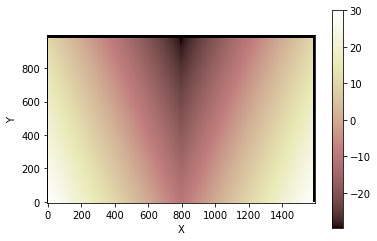

In [73]:
plt.figure()
imshow_grid(basin,'water_table__elevation')

The grid is square with dimensions 500x500m. The surface elevation and aquifer base have the same concave parabolic shape, with thickness 2m between them. The aquifer is initially fully saturated (water table at the surface). Water is only allowed to exit the domain through a single node in the the lower left corner. All other boundaries are closed.  

## Simulate constant groundwater recharge

Now initialize the model components. In addition to the grid, the GroundwaterDupuitPercolator takes four optional arguments: hydraulic conductivity, porosity, recharge rate, and a regularization factor that smooths the transition between subsurface and surface flow as the water table approaches the ground surface. The greater the value, the smoother the transition.

You will also initialize a FlowAccumulator in order to use an included method to calculate the surface water discharge out of the domain. The runoff rate used by the FlowAccumulator is the surface water specific discharge from the groundwater model.

In [74]:
K = 0.01 # hydraulic conductivity, (m/s)
R = 1e-5 #1e-7 # recharge rate, (m/s)
n = 0.2 # porosity, (-)
gdp = GroundwaterDupuitPercolator(
    basin, 
    hydraulic_conductivity=K, 
    porosity=n, 
    recharge_rate=R,
    regularization_f=0.01)
fa = FlowAccumulator(
    basin, 
    surface='topographic__elevation',
    flow_director='FlowDirectorSteepest', 
    runoff_rate='surface_water__specific_discharge')

Next, run the model forward in time, and track the fluxes leaving the domain.

In [84]:
N = 500
dt = 1E2

recharge_flux = np.zeros(N)
gw_flux = np.zeros(N)
sw_flux = np.zeros(N)
storage = np.zeros(N)
s0 = gdp.calc_total_storage()

for i in range(N):    
    gdp.run_with_adaptive_time_step_solver(dt)  
    fa.run_one_step()
    
    storage[i] = gdp.calc_total_storage()
    recharge_flux[i] = gdp.calc_recharge_flux_in()
    gw_flux[i] = gdp.calc_gw_flux_out()
    sw_flux[i] = gdp.calc_sw_flux_out()
    

/Users/allen/Documents/Python/landlab/landlab/components/groundwater/dupuit_percolator.py:777: RuntimeWarning: divide by zero encountered in true_divide
  self._n_link * self._grid.length_of_link ** 2 / (4 * self._K * hlink)
/Users/allen/Documents/Python/landlab/landlab/components/groundwater/dupuit_percolator.py:781: RuntimeWarning: divide by zero encountered in true_divide
  self._grid.length_of_link / abs(self._vel / self._n_link)
/Users/allen/Documents/Python/landlab/landlab/components/groundwater/dupuit_percolator.py:706: UserWarning: water table above elevation surface. Setting water table elevation here to elevation surface
  warn(


Now visualize some results.

In [45]:
basin['node']['surface_water__discharge']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

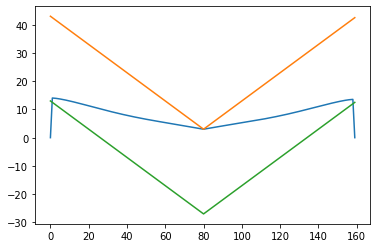

In [88]:
plt.plot(basin.at_node['water_table__elevation'].reshape(basin.shape)[85,:])
# plt.plot(basin)
plt.plot(basin.at_node['topographic__elevation'].reshape(basin.shape)[85,:])
plt.plot(basin.at_node['aquifer_base__elevation'].reshape(basin.shape)[85,:])

<Figure size 432x288 with 0 Axes>

/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


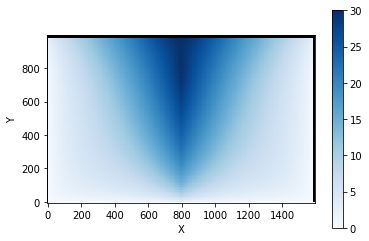

In [86]:
plt.figure()
imshow_grid(basin,wt-base,cmap='Blues')


/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)
/Users/allen/Documents/Python/landlab/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


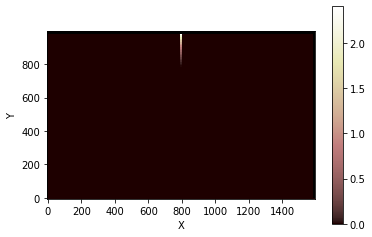

In [89]:
imshow_grid(basin, 'surface_water__discharge')

The above shows how saturated the aquifer is. Note that it is most saturated at the lowest area of the domain, nearest the outlet.

Now look at the mass balance by ploting cumulative fluxes. The cumulative recharge in should be equal to cumulative fluxes out (groundwater and surface water) plus the change in storage from the initial condition.

<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'Cumulative Volume $[m^3]$')

Text(0.5, 0, 'Time [h]')

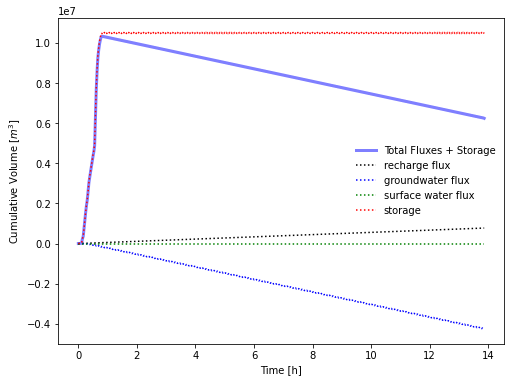

In [31]:
t = np.arange(0,N*dt,dt)

plt.figure(figsize=(8,6))
plt.plot(t/3600,
         np.cumsum(gw_flux)*dt+np.cumsum(sw_flux)*dt+storage-s0,
         'b-',
         linewidth=3, 
         alpha=0.5,
         label='Total Fluxes + Storage')
plt.plot(t/3600,np.cumsum(recharge_flux)*dt-recharge_flux[0]*dt,'k:',label='recharge flux')
plt.plot(t/3600,np.cumsum(gw_flux)*dt,'b:',label='groundwater flux')
plt.plot(t/3600,np.cumsum(sw_flux)*dt,'g:',label='surface water flux')
plt.plot(t/3600,storage-s0, 'r:', label='storage')
plt.ylabel('Cumulative Volume $[m^3]$')
plt.xlabel('Time [h]')
plt.legend(frameon=False)
plt.show()

The thick blue line (cumulative fluxes plus storage) matches the black cumulative recharge flux line, which indicates that the model has conserved mass. Because the initial domain was fully saturated, the primary feature that shows up in this mass balance is the loss of that initial water. It will be easier to see what is going on here in the second example. 

### Check conservation of mass with changing recharge

Now check to confirm that mass is conserved with different recharge rates.

In [8]:
wt0 = wt.copy()

K = 0.01 # hydraulic conductivity, (m/s)
R = np.array([1e-5, 1e-6, 1e-7, 1e-8]) # recharge rate, (m/s)
por = 0.2 # porosity, (-)

f_in = np.zeros(len(R))
f_out = np.zeros(len(R))

for n in range(len(R)):
    
    boundaries = {'top': 'closed','bottom': 'closed','right':'closed','left':'closed'}
    grid = RasterModelGrid((51, 51), xy_spacing=10.0, bc=boundaries)
    grid.status_at_node[1] = grid.BC_NODE_IS_FIXED_VALUE

    elev = grid.add_zeros('node', 'topographic__elevation')
    elev[:] = (0.001*grid.x_of_node**2 + 0.001*grid.y_of_node**2)+2

    base = grid.add_zeros('node', 'aquifer_base__elevation')
    base[:] = elev - 2

    wt = grid.add_zeros('node', 'water_table__elevation')
    wt[:] = wt0.copy()

    gdp = GroundwaterDupuitPercolator(
        grid, 
        hydraulic_conductivity=K, 
        porosity=por, 
        recharge_rate=R[n],
        regularization_f=0.01, 
        courant_coefficient=0.1)
    fa = FlowAccumulator(
        grid, 
        surface='topographic__elevation',
        flow_director='FlowDirectorSteepest', 
        runoff_rate='surface_water__specific_discharge')
    
    N = 250
    dt = 1E2

    recharge_flux = np.zeros(N)
    gw_flux = np.zeros(N)
    sw_flux = np.zeros(N)
    storage = np.zeros(N)
    s0 = gdp.calc_total_storage()

    for i in range(N):

        gdp.run_one_step(dt)
        fa.run_one_step()
        
        recharge_flux[i] = gdp.calc_recharge_flux_in()
        gw_flux[i] = gdp.calc_gw_flux_out()
        sw_flux[i] = gdp.calc_sw_flux_out()
        storage[i] = gdp.calc_total_storage()

    f_in[n] = np.sum(recharge_flux)*dt
    f_out[n] = np.sum(gw_flux)*dt+np.sum(sw_flux)*dt+storage[-1]-s0


/Users/allen/Documents/Python/landlab/landlab/components/groundwater/dupuit_percolator.py:623: UserWarning: water table above elevation surface. Setting water table elevation here to elevation surface
  warn(


The code above simulates the evolution of the water table under four different recharge rates, and calculates the fluxes across the domain boundaries and the change in storage. It then sums the fluxes to find out the total volume in and out and change in storage. Below we visualize how flow in compares with flow out plus storage change. If mass is conserved they should be the same.

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'flux out + storage $(m^3)$')

Text(0.5, 0, 'flux in $(m^3)$')

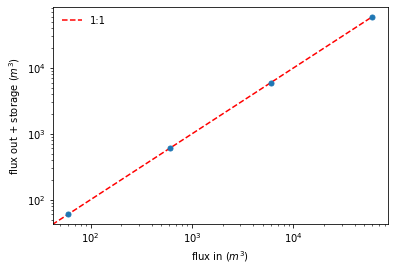

In [9]:
x11 = np.linspace(0,max(f_in))

plt.figure()
plt.loglog(x11,x11,'r--', label='1:1')
plt.loglog(f_in,f_out,'.',markersize=10)
plt.legend(frameon=False)
plt.ylabel('flux out + storage $(m^3)$')
plt.xlabel('flux in $(m^3)$')
plt.show()

The trials plot close to the 1:1 line, showing that we are close to mass conservation. Just how close? Calculate the relative error below.

In [10]:
(f_in-f_out)/f_in

array([  4.42282458e-05,   8.33677223e-09,  -2.90403761e-09,
        -1.78236752e-08])

### Check conservation of mass with changing timestep

To check conservation of mass with different timesteps, we will use the method `run_with_adaptive_time_step_solver` to ensure the model remains stable. This method is the same as run_one_step, except that it subdivides the provided timestep (event or inter-event duration in this case) in order to meet a Courant-type stability criterion.

We can set the `courant_coefficient` either as an argument when we create the component, or by setting the attribute `gdp.courant_coefficient`. This value indicates how large the maximum allowed timestep is relative to the Courant limit. Values close to 0.1 are recommended for best results.

For efficiency, fluxes are only calculated at the end of each large timestep when using `run_with_adaptive_time_step_solver`, not during the internally subdivided timesteps. As a result, deviations from mass conservation are possible.

In [ ]:
wt0 = wt.copy()

K = 0.01 # hydraulic conductivity, (m/s)
R = 1e-7 # recharge rate, (m/s)
por = 0.2 # porosity, (-)
N_all = np.array([10,50,100,500,1000]) # number of timesteps
T = 24*3600 # total time
dt_all = T/N_all # timestep
gdp.courant_coefficient = 0.2

f_in = np.zeros(len(N_all))
f_out = np.zeros(len(N_all))

for n in range(len(N_all)):
    
    boundaries = {'top': 'closed','bottom': 'closed','right':'closed','left':'closed'}
    grid = RasterModelGrid((51, 51), xy_spacing=10.0, bc=boundaries)
    grid.status_at_node[1] = grid.BC_NODE_IS_FIXED_VALUE

    elev = grid.add_zeros('node', 'topographic__elevation')
    elev[:] = (0.001*grid.x_of_node**2 + 0.001*grid.y_of_node**2)+2

    base = grid.add_zeros('node', 'aquifer_base__elevation')
    base[:] = elev - 2

    wt = grid.add_zeros('node', 'water_table__elevation')
    wt[:] = wt0.copy()

    gdp = GroundwaterDupuitPercolator(
        grid, 
        hydraulic_conductivity=K, 
        porosity=por, 
        recharge_rate=R,
        regularization_f=0.01, 
        courant_coefficient=0.1)
    fa = FlowAccumulator(
        grid, 
        surface='topographic__elevation',
        flow_director='FlowDirectorSteepest', 
        runoff_rate='surface_water__specific_discharge')
    
    N = N_all[n]
    dt = dt_all[n]

    recharge_flux = np.zeros(N)
    gw_flux = np.zeros(N)
    sw_flux = np.zeros(N)
    storage = np.zeros(N)
    s0 = gdp.calc_total_storage()
    
    for i in range(N):
        
        gdp.run_with_adaptive_time_step_solver(dt)

        fa.run_one_step()
        
        recharge_flux[i] = gdp.calc_recharge_flux_in()
        gw_flux[i] = gdp.calc_gw_flux_out()
        sw_flux[i] = gdp.calc_sw_flux_out()
        storage[i] = gdp.calc_total_storage()

    f_in[n] = np.sum(recharge_flux)*dt
    f_out[n] = np.sum(gw_flux)*dt+np.sum(sw_flux)*dt+storage[-1]-s0


The code above simulates the evolution of the water table for the same total amount of time, but using four different values for the timestep. Just as before, fluxes and storage are calculated, along with their totals. Again, look at the relative error in mass conservation.

In [ ]:
(f_in-f_out)/f_in

## Simulate time-varying recharge

Lastly, simulate time-varying recharge, look at the mass balance, and the outflow hydrograph. This will use the same grid and groundwater model instance as above, taking the final condition of the previous model run as the new initial condition here. This time the adaptive timestep solver will be used to make sure the model remains stable.

First, we need a distribution of recharge events. We will use landlab's precipitation distribution tool to create a lists paired recharge events and intensities.

In [ ]:
#generate storm timeseries
T = 10*24*3600 #sec
Tr = 1*3600 #sec
Td = 24*3600 #sec
dt = 1e3 #sec
p = 1e-3 #m

precip = PrecipitationDistribution(
    mean_storm_duration=Tr, 
    mean_interstorm_duration=Td, 
    mean_storm_depth=p, 
    total_t=T, 
    delta_t=dt)
durations = []
intensities = []
precip.seed_generator(seedval=1)
for (interval_duration, rainfall_rate_in_interval) in (
                precip.yield_storm_interstorm_duration_intensity(subdivide_interstorms=True)
):
    durations.append(interval_duration)
    intensities.append(rainfall_rate_in_interval)
N = len(durations)  

Next, run the model forward with the adaptive timestep solver.

In [ ]:
recharge_flux = np.zeros(N)
gw_flux = np.zeros(N)
sw_flux = np.zeros(N)
storage = np.zeros(N)
s0 = gdp.calc_total_storage()
num_substeps = np.zeros(N)

gdp.courant_coefficient = 0.2

for i in range(N):
    gdp.recharge = intensities[i]*np.ones_like(gdp.recharge)
    
    gdp.run_with_adaptive_time_step_solver(durations[i])
    fa.run_one_step()
    
    num_substeps[i] = gdp.number_of_substeps
    recharge_flux[i] = gdp.calc_recharge_flux_in()
    gw_flux[i] = gdp.calc_gw_flux_out()
    sw_flux[i] = gdp.calc_sw_flux_out()
    storage[i] = gdp.calc_total_storage()



Again, visualize the mass balance:

In [ ]:
t = np.cumsum(durations)

plt.figure()
plt.plot(t/3600,
         np.cumsum(gw_flux*durations)+np.cumsum(sw_flux*durations)+storage-s0,
         'b-',
         linewidth=3, 
         alpha=0.5,
         label='Total Fluxes + Storage')
plt.plot(t/3600,np.cumsum(recharge_flux*durations),'k:',label='recharge flux')
plt.plot(t/3600,np.cumsum(gw_flux*durations),'b:',label='groundwater flux')
plt.plot(t/3600,np.cumsum(sw_flux*durations),'g:',label='surface water flux')
plt.plot(t/3600,storage-storage[0], 'r:', label='storage')
plt.ylabel('Cumulative Volume $[m^3]$')
plt.xlabel('Time [h]')
plt.legend(frameon=False)
plt.show()

Visualize numer of substeps that the model took for stability:

In [ ]:
plt.figure()
plt.plot(num_substeps,'.')
plt.xlabel('Iteration')
plt.ylabel('Numer of Substeps')
plt.yticks([1,5,10,15,20])
plt.show()

In [ ]:
max(num_substeps)

The method has subdivided the timestep up to 18 times in order to meet the stability criterion. This is dependent on a number of factors, including the Courant coefficient, the hydraulic conductivity, and hydraulic gradient.

Now look at the timeseries of recharge in and groundwater and surface water leaving the domain at the open node:

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(t/(3600*24),sw_flux, label='Surface water flux')
ax.plot(t/(3600*24),gw_flux, label='Groundwater flux')
ax.set_ylim((0,0.04))
ax.set_ylabel('Flux out $[m^3/s]$')
ax.set_xlabel('Time [d]')
ax.legend(frameon=False,loc=7)
ax1 = ax.twinx()
ax1.plot(t/(3600*24),recharge_flux,'0.6')
ax1.set_ylim((1.2,0))
ax1.set_ylabel('Recharge flux in $[m^3/s]$')
plt.show()

The relationship between maximum flux that can be passed through the subsurface and the occurrence of groundwater seepage is clear from this figure.

## Using different boundary conditions

So far, we have used the fixed fixed value "open" boundary condition, and zero flux "closed" boundary condition. Fixed gradient (von Neumann) boundary conditions are also supported by this component. When fixed value is selected, the water table elevation remains fixed on the specified boundary nodes. When fixed gradient is selected, the water table gradient on specified links remains fixed.

Below is an example of setting fixed gradient links on one boundary.

In [ ]:
grid = RasterModelGrid((10, 10), xy_spacing=10.0)
grid.set_status_at_node_on_edges(right=grid.BC_NODE_IS_CLOSED, top=grid.BC_NODE_IS_CLOSED, \
                              left=grid.BC_NODE_IS_CLOSED, bottom=grid.BC_NODE_IS_FIXED_GRADIENT)

elev = grid.add_zeros('node', 'topographic__elevation')
elev[:] =  (0.001*(grid.x_of_node-100)**2 + 0.0002*grid.y_of_node**2)+10
base = grid.add_zeros('node', 'aquifer_base__elevation')
base[:] = elev - 2
wt = grid.add_zeros('node', 'water_table__elevation')
wt[:] = elev

gdp = GroundwaterDupuitPercolator(grid)

Say we want to set the bottom boundary gradients to be equal to the slope of the topographic surface. This can be done simply as follows:

In [ ]:
#calculate surface slopes
S = grid.calc_grad_at_link(elev)

# assign hydraulic gradient at fixed linlks to be the surface slope there
grid.at_link['hydraulic__gradient'][grid.fixed_links] = S[grid.fixed_links]

grid.at_link['hydraulic__gradient'][grid.fixed_links]

For more information on setting boundary conditions, please see the `boundary_conds` folder within `landlab/notebooks/tutorials`. 

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>